In [1]:
import numpy as np
from scipy.stats import norm
import random
import pandas as pd
from tqdm import tqdm  

# Define the number of politicians and the dimensionality of the ideal points
dim_ideal_points = 1
num_politicians = 10000
num_bills = 100
doc_length = 1000
vocab_size = 500
num_survey_questions = 100

# Define the parameters of the normal distribution for ideal points
mean_ideal_points = np.zeros(dim_ideal_points)
cov_ideal_points = np.eye(dim_ideal_points)

# Generate ideal points for politicians
ideal_points = np.random.multivariate_normal(mean_ideal_points, cov_ideal_points, num_politicians)

# Function to generate speeches based on ideal points
def generate_speeches(ideal_points, doc_length, vocab_size, progress_bar=False):
    ideal_point_word_matrix = np.random.rand(ideal_points.shape[1], vocab_size)
    
    if progress_bar:
        iterator = tqdm(range(ideal_points.shape[0]))
    else:
        iterator = range(ideal_points.shape[0])
    documents = []
    for i in iterator:
        doc_ideal_points = ideal_points[i]
        doc_words = []
        word_probs = np.dot(doc_ideal_points, ideal_point_word_matrix)
        word_probs = np.exp(word_probs) / np.sum(np.exp(word_probs))
        for _ in range(doc_length):
            word_index = np.random.choice(vocab_size, p=word_probs)
            doc_words.append('word_' + str(word_index))
        doc_words = ' '.join(doc_words)
        documents.append(doc_words)
    return documents

# Function to generate voting behavior based on ideal points
def generate_voting(ideal_points, num_bills, progress_bar=False):
    votes = []
    if progress_bar:
        iterator = tqdm(range(num_bills))
    else:
        iterator = range(num_bills)
    for bill in iterator:
        bill_position = np.random.randn(dim_ideal_points)  # Position of the bill in the ideal point space
        vote_probs = norm.cdf(np.dot(ideal_points, bill_position))  # Probability of voting 'yes'
        votes.append(np.random.binomial(1, vote_probs))
    return np.array(votes).T

# Function to generate survey answers based on ideal points
def generate_survey_answers(ideal_points, num_survey_questions, progress_bar=False):
    survey_answers = []
    if progress_bar:
        iterator = tqdm(range(num_survey_questions))
    else:
        iterator = range(num_survey_questions)
    for survey in iterator:
        categories_per_survey = np.random.randint(2, 6)  # Random number of categories between 2 and 5
        survey_position = np.random.randn(dim_ideal_points, categories_per_survey)  # Position of each category in the ideal point space
        # Calculate the scores for each category
        scores = np.dot(ideal_points, survey_position)
        # Convert scores to probabilities using softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))  # Stability fix for softmax
        answer_probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        # Select the category with the highest probability
        answers = [np.random.choice(categories_per_survey, p=answer_probs[i]) for i in range(ideal_points.shape[0])]
        survey_answers.append(answers)
    return np.array(survey_answers).T

# Generate speeches, voting behavior, and survey answers based on ideal points
speeches = generate_speeches(
    ideal_points,
    doc_length=doc_length,
    vocab_size=vocab_size,
    progress_bar=True
)
voting = generate_voting(
    ideal_points,
    num_bills=num_bills,
    progress_bar=True
)
survey_answers = generate_survey_answers(
    ideal_points,
    num_survey_questions=num_survey_questions,
    progress_bar=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.45it/s]


In [2]:
# Create a DataFrame with speeches and voting behavior
data = pd.DataFrame({'doc_clean': speeches, 'i': range(1, num_politicians + 1)})
vote_cols = [f'vote_{i+1}' for i in range(num_bills)]
vote_data = pd.DataFrame(voting, columns=vote_cols)
survey_cols = [f'Q_{i+1}' for i in range(num_survey_questions)]
survey_data = pd.DataFrame(survey_answers, columns=survey_cols)
data = pd.concat([data, vote_data, survey_data], axis=1)

data['cov0'] = np.random.rand(num_politicians)
data['cov1'] = np.random.rand(num_politicians)
data['t'] = 1

# Print the DataFrame
print(data.head())

                                           doc_clean  i  vote_1  vote_2  \
0  word_457 word_307 word_364 word_487 word_233 w...  1       1       1   
1  word_422 word_42 word_17 word_110 word_118 wor...  2       0       1   
2  word_28 word_234 word_63 word_135 word_62 word...  3       1       1   
3  word_325 word_412 word_303 word_25 word_219 wo...  4       1       1   
4  word_182 word_493 word_400 word_208 word_21 wo...  5       1       1   

   vote_3  vote_4  vote_5  vote_6  vote_7  vote_8  ...  Q_94  Q_95  Q_96  \
0       1       1       0       0       1       0  ...     2     1     1   
1       1       1       1       1       1       1  ...     1     0     0   
2       1       0       0       0       0       0  ...     4     0     1   
3       1       0       0       0       0       1  ...     2     0     0   
4       1       1       1       1       1       1  ...     1     1     1   

   Q_97  Q_98  Q_99  Q_100      cov0      cov1  t  
0     2     2     1      1  0.423538  0.

In [3]:
import sys
sys.path.append('../IdealPointNN/')
from dataset import IdealPointNNDataset
from ideal_point_model import IdealPointNN

train_data = IdealPointNNDataset(
    data,
    ideology = "~ cov0 + cov1"
)
train_data.add_modality(modality = 'text')
train_data.add_modality(
    modality = 'vote',
    columns = ['vote_{}'.format(i+1) for i in range(num_bills)]
)
train_data.add_modality(
    modality = 'discrete_choice',
    columns = ['Q_{}'.format(i+1) for i in range(num_survey_questions)]
)

/home/germain/Documents/neural_ideal_points/neural_ideal_point_models/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_data.modalities

['text', 'vote', 'discrete_choice']

In [5]:
train_datasets = [train_data]

In [6]:
m = IdealPointNN(
    train_datasets, 
    n_dims=dim_ideal_points,
    update_prior=True,
    log_every_n_epochs = 1,
    dropout = 0,
    w_prior = 1,
    print_every_n_batches=1000,
    learning_rate=1e-3,
    patience=1
)


Epoch   1	Mean Training Loss:1750.4122853


Epoch   2	Mean Training Loss:2354.7113237


Early stopping at Epoch 2. Reverting to Epoch 1


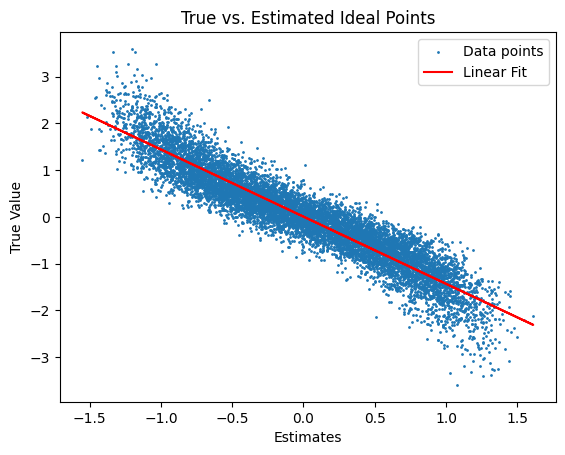

In [7]:
import numpy as np
import matplotlib.pyplot as plt

doc_dims = m.get_ideal_points(train_datasets, modality='discrete_choice')

x = doc_dims
y = ideal_points

plt.scatter(x, y, label='Data points', s=1)
coefficients = np.polyfit(x.flatten(), y.flatten(), 1)
fit = np.poly1d(coefficients)
plt.plot(x, fit(x), color='red', label='Linear Fit')
plt.xlabel('Estimates')
plt.ylabel('True Value')
plt.title('True vs. Estimated Ideal Points')
plt.legend()
plt.show()

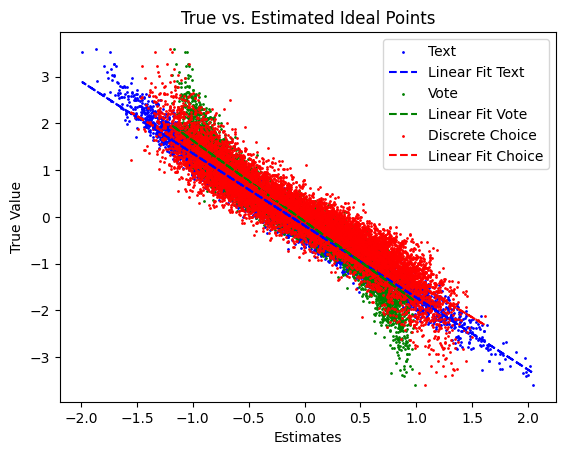

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x1 = m.get_ideal_points(train_datasets, modality='text')
x2 = m.get_ideal_points(train_datasets, modality='vote')
x3 = m.get_ideal_points(train_datasets, modality='discrete_choice')

# Plot the first set
plt.scatter(x1, y, label='Text', s=1, color='blue')
coefficients_1 = np.polyfit(x1.flatten(), y.flatten(), 1)
fit_1 = np.poly1d(coefficients_1)
plt.plot(x1, fit_1(x1), color='blue', linestyle='--', label='Linear Fit Text')

# Plot the second set
plt.scatter(x2, y, label='Vote', s=1, color='green')
coefficients_2 = np.polyfit(x2.flatten(), y.flatten(), 1)
fit_2 = np.poly1d(coefficients_2)
plt.plot(x2, fit_2(x2), color='green', linestyle='--', label='Linear Fit Vote')

# Plot the third set
plt.scatter(x3, y, label='Discrete Choice', s=1, color='red')
coefficients_3 = np.polyfit(x3.flatten(), y.flatten(), 1)
fit_3 = np.poly1d(coefficients_3)
plt.plot(x3, fit_3(x3), color='red', linestyle='--', label='Linear Fit Choice')

plt.xlabel('Estimates')
plt.ylabel('True Value')
plt.title('True vs. Estimated Ideal Points')
plt.legend()
plt.show()

In [9]:
np.corrcoef(x1[:,0],x3[:,0])

array([[1.        , 0.92159519],
       [0.92159519, 1.        ]])

In [10]:
print('Estimated lambda: {}'.format(m.prior.lambda_))
print('Estimated sigma: {}'.format(m.prior.sigma))

Estimated lambda: tensor([[0.0073],
        [0.0000],
        [0.0000]], device='cuda:0')
Estimated sigma: tensor([[0.4265]], device='cuda:0')
